# Table of contents
1. [Introduction](#introduction)
2. [Data](#data)
3. [Basic Visualization](#vis)
3. [Find the Clusters](#find_clusters)
    1. [Dimensionality Reduction?](#dimred)
    2. [Apply t-SNE and bh-SNE](#sne) 
3. [Conclution](#conclu)


# Introduction <a name='introduction'></a>
Can we use unsupervised learning and clustering to divide people into groups based on how they spend their days? The first part of the problem is to find if it is possible in general to categorise people in this way. The second part is to find how many groups there would be and how they interact with each other.

We will be using two methods, t-SNE and bh-SNE. Originally this project was supposed to use only t-SNE but further research resulted in the use of bh-SNE. T-SNE is an effective mean for dimension reducion but compared to bh-SNE it is computationally heavy (runnin in O(n2) time). Barnes-Hut t-Distributed Stochastic Neighbor Embedding (BH-SNE) runs in O(n log n) time and is an effective means of quick dimension reduction with little loss in fidelity (https://arxiv.org/pdf/1301.3342v2.pdf)

### What next?
- Import the functions we need
- Load the dataset
- Use TruncatedSVD for dimensionality  reduction to make it into a surprisingly informative smaller matrix
- Use KMeans to group our participants into some clusters
- Use t-SNE and bh-SNE to get coordinates for a scatterplot
- Visualize the results

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

import seaborn as sns
from plotly.graph_objs import *
import plotly.plotly as py
import plotly.tools as tls

import sklearn.cluster as cluster
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from sklearn.metrics import silhouette_score

from tsne import bh_sne
import time

%matplotlib inline

# Data <a name='data'></a>
The American Time Use Survey (ATUS) is the Nation’s first federally administered, continuous survey on time use in the United States. The goal of the survey is to measure how people divide their time (in minutes) among life’s activities. Our data comes from the ATUS dataset, from the year 2003 to 2015.

We start by importing our datasets. We will import the full `big_data` sets that contains all the time entries from the 170,842 participants to use for our visualization . To use for our calculations we will import both the `s5` and `s10` datasets where we have taken a sample of 5,000 and 10,000 participants. The full dataset is to big for the MacBookPro being used for the creation of this project.

We will also import `the_data` data set where the time entries have been manually merged from 431 features to 83 features. This will give us a different prespective on the data.

In [86]:
big_data = pd.read_csv('big_data.csv')
s10_big_data = pd.read_csv('s10big_data.csv')
the_data = pd.read_csv('the_data.csv')
s10_the_data = pd.read_csv('s10_the_data.csv')

In [67]:
#from sklearn.preprocessing import normalize

#big_data = normalize(a_big_data, norm='l1', axis=1)
#s10_big_data = normalize(a_s10_big_data, norm='l1', axis=1)
#the_data = normalize(a_the_data, norm='l1', axis=1)
#s10_the_data = normalize(a_s10_the_data, norm='l1', axis=1)

# Find the clusters <a name='find_clusters')></a>
We have successfully imported the data and visualized it to get some basic knowledge about it. Now we are going to see if we can actually cluster the respondents and divide them into some sort of groups or clusters. 


### Let's get started...

**Should we center the matrix?**

Centering sparse data would destroy the sparseness structure in the data, and thus rarely is a sensible thing to do. However, it can make sense to scale sparse inputs, especially if features are on different scales 

(http://scikit-learn.org/stable/modules/preprocessing.html).

## Dimensionality reduction <a name='dimred'></a>
There are many zeroes in our data. In this part I will use both the manually merged data ('the_data') and the dimensionality reduced data of 'big_data' where the data points have not been manually merged. Because of the sparsity of the data (88% and 97%) we will use the ARPACK wrapper (scipy.sparse.linalg.svds) with the TruncatedSVD.

In [87]:
%%time
svd = TruncatedSVD(algorithm='arpack', n_components=10)
embedded_coords = normalize(svd.fit_transform(s10_big_data), norm='l1')

CPU times: user 652 ms, sys: 35.7 ms, total: 688 ms
Wall time: 382 ms


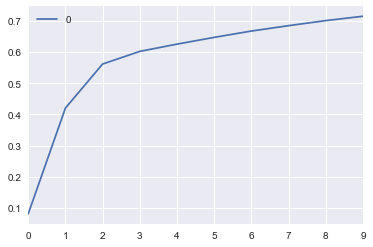

In [88]:
pd.DataFrame(np.cumsum(svd.explained_variance_ratio_)).plot()

It seems like we can compress the 431 features into 100 components loosing less than 10% variance. It seems wee are not gaining to much after the first 40 components, where we are maintaining about 90% of the variance.

In [89]:
%%time

svd1 = TruncatedSVD(algorithm='arpack', n_components=10)
embedded_coords1 = normalize(svd1.fit_transform(s10_the_data), norm='l1')

CPU times: user 149 ms, sys: 10.2 ms, total: 159 ms
Wall time: 125 ms


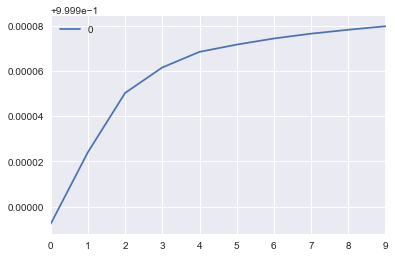

In [90]:
pd.DataFrame(np.cumsum(svd1.explained_variance_ratio_)).plot()

## Apply t-SNE and bh-SNE <a name='sne'></a>

Now we´ll run twi kind of embedding techniques to get coordinates for our scatterplots, the t-SNE and the bh-SNE. The t-SNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. The bh-SNE uses vantage-point trees to compute sparse pairwise similarities between the input data objects, and it uses a variant of the Barnes-Hut algorithm to approximate the forces between the corresponding points in the embedding.

Former experiments (https://arxiv.org/pdf/1301.3342v2.pdf) have shown that bh-SNE (normally runs in O(N log N)) leads to substantial computational advantages over standard t-SNE (normally runs in O(N2) wich makes it more suitable for bigger datasets.

### t-SNE with SVD

In [91]:
%%time

result = TSNE(n_components=2, random_state=0).fit_transform(embedded_coords)

CPU times: user 4min 47s, sys: 1min 12s, total: 6min
Wall time: 5min 28s


### bh-SNE with SVD

In [92]:
%%time

result_emb_bh = bh_sne(embedded_coords1)

CPU times: user 1min 4s, sys: 927 ms, total: 1min 5s
Wall time: 1min 8s


### bh-SNE directly 

In [93]:
%%time

result_bh = bh_sne(s10_big_data)

CPU times: user 1min 31s, sys: 1.22 s, total: 1min 32s
Wall time: 1min 34s


### t-SNE with SVD on data on manually merged data

In [94]:
%%time

result2 = TSNE(n_components=2, random_state=0).fit_transform(embedded_coords2)

CPU times: user 4min 35s, sys: 1min 9s, total: 5min 44s
Wall time: 5min 15s


### bh-SNE with SVD on data on manually merged data

In [95]:
%%time

result_emb_bh_the_data = bh_sne(embedded_coords2)

CPU times: user 1min 10s, sys: 1.11 s, total: 1min 11s
Wall time: 1min 17s


### bh-SNE directly on manually merged data

In [96]:
%%time

result_bh_the_data = bh_sne(s10_the_data)

CPU times: user 1min 11s, sys: 1.07 s, total: 1min 12s
Wall time: 1min 14s


We can clearly see that t-SNE with SVD requiers significantly more Wall time than bh-SNE with and without SVD. Lets see what gives us the best clustering results.

# Clustering with KMeans

We´ll run a silhouette_score to decide the amount of clusters.

In [97]:
cluster_range = list(range(2,20)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_cluster, random_state=2).fit(result)
    
    # Predict the cluster for each data point
    preds = clusterer.predict(result)
      
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)
    
#Score for 2 - 99 clusters ranges from 0.36 to 0.46 and continuing going up.

The score for n_cluster = 2. is : 0.351928701397
The score for n_cluster = 3. is : 0.378793293798
The score for n_cluster = 4. is : 0.366325379034
The score for n_cluster = 5. is : 0.35375179414
The score for n_cluster = 6. is : 0.353872799534
The score for n_cluster = 7. is : 0.374089741288
The score for n_cluster = 8. is : 0.356905252204
The score for n_cluster = 9. is : 0.345364904447
The score for n_cluster = 10. is : 0.354369859913
The score for n_cluster = 11. is : 0.362554492147
The score for n_cluster = 12. is : 0.358559835219
The score for n_cluster = 13. is : 0.366275946315
The score for n_cluster = 14. is : 0.355080059492
The score for n_cluster = 15. is : 0.357410782717
The score for n_cluster = 16. is : 0.357501050008
The score for n_cluster = 17. is : 0.363628558237
The score for n_cluster = 18. is : 0.363165362331
The score for n_cluster = 19. is : 0.371460909139


In [102]:
from sklearn.mixture import GaussianMixture as GMM

cluster_range = list(range(2,10)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GMM(n_components=n_cluster, random_state=2).fit(result)
    
    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(result)
    
    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(result)
    
    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.352760392441
The score for n_cluster = 3. is : 0.378397499304
The score for n_cluster = 4. is : 0.365267240298
The score for n_cluster = 5. is : 0.351994249283
The score for n_cluster = 6. is : 0.350926368709
The score for n_cluster = 7. is : 0.369179323052
The score for n_cluster = 8. is : 0.36299126925
The score for n_cluster = 9. is : 0.3511974885


In [186]:
#from sklearn.mixture import GaussianMixture as GMM

cluster_range = list(range(2,10)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = DBSCAN().fit_predict(result)
    
    # TODO: Predict the cluster for each data point
    #preds = clusterer.predict(result)
    
    # TODO: Predict the cluster for each transformed sample data point
    #sample_preds = clusterer.predict(result)
    
    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.32353815185
The score for n_cluster = 3. is : 0.32353815185
The score for n_cluster = 4. is : 0.32353815185
The score for n_cluster = 5. is : 0.32353815185
The score for n_cluster = 6. is : 0.32353815185
The score for n_cluster = 7. is : 0.32353815185
The score for n_cluster = 8. is : 0.32353815185
The score for n_cluster = 9. is : 0.32353815185


In [99]:
cluster_range = list(range(2,20)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_cluster, random_state=2).fit(result_emb_bh)

    # Predict the cluster for each data point
    preds = clusterer.predict(result_emb_bh)
      
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(result_emb_bh, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)
    
#Score for 2 - 99 clusters ranges from 0.38 to 0.42 at 48 clusters.

The score for n_cluster = 2. is : 0.372958067626
The score for n_cluster = 3. is : 0.394873890847
The score for n_cluster = 4. is : 0.369045451017
The score for n_cluster = 5. is : 0.378046837689
The score for n_cluster = 6. is : 0.416854421901
The score for n_cluster = 7. is : 0.40147926208
The score for n_cluster = 8. is : 0.391822669722
The score for n_cluster = 9. is : 0.39784411828
The score for n_cluster = 10. is : 0.392706746437
The score for n_cluster = 11. is : 0.405044894014
The score for n_cluster = 12. is : 0.410109850063
The score for n_cluster = 13. is : 0.400384774218
The score for n_cluster = 14. is : 0.393502793329
The score for n_cluster = 15. is : 0.400242883121
The score for n_cluster = 16. is : 0.39719810479
The score for n_cluster = 17. is : 0.402243845805
The score for n_cluster = 18. is : 0.4002063569
The score for n_cluster = 19. is : 0.3986117549


In [121]:
cluster_range = list(range(2,10)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GMM(n_components=n_cluster, random_state=2).fit(result_emb_bh)
    
    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(result_emb_bh)

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(result_emb_bh)
    
    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(result_emb_bh, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.368310366245
The score for n_cluster = 3. is : 0.393182371562
The score for n_cluster = 4. is : 0.35964031584
The score for n_cluster = 5. is : 0.359754358517
The score for n_cluster = 6. is : 0.358613147729
The score for n_cluster = 7. is : 0.33709950366
The score for n_cluster = 8. is : 0.363493843305
The score for n_cluster = 9. is : 0.373961402271


In [29]:
cluster_range = list(range(2,20)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_cluster, random_state=2).fit(result_bh)
    
    # Predict the cluster for each data point
    preds = clusterer.predict(result_bh)
      
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(result_bh, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

#Highest score is for 3 clusters = 0.436

The score for n_cluster = 2. is : 0.438789878863
The score for n_cluster = 3. is : 0.419731204087
The score for n_cluster = 4. is : 0.404722005176
The score for n_cluster = 5. is : 0.370843754996
The score for n_cluster = 6. is : 0.385107326113
The score for n_cluster = 7. is : 0.354160557299
The score for n_cluster = 8. is : 0.353247653184
The score for n_cluster = 9. is : 0.353550953024
The score for n_cluster = 10. is : 0.362616306579
The score for n_cluster = 11. is : 0.371916632447
The score for n_cluster = 12. is : 0.379359025846
The score for n_cluster = 13. is : 0.385838856658
The score for n_cluster = 14. is : 0.386404072721
The score for n_cluster = 15. is : 0.386393701298
The score for n_cluster = 16. is : 0.383957515243
The score for n_cluster = 17. is : 0.381592259268
The score for n_cluster = 18. is : 0.382309435237
The score for n_cluster = 19. is : 0.385868637038


In [79]:
cluster_range = list(range(2,10)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_cluster, random_state=2).fit(result2)
    
    # Predict the cluster for each data point
    preds = clusterer.predict(result2)
      
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(result2, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)


The score for n_cluster = 2. is : 0.340802862634
The score for n_cluster = 3. is : 0.371722076249
The score for n_cluster = 4. is : 0.363704534577
The score for n_cluster = 5. is : 0.342412839779
The score for n_cluster = 6. is : 0.367837972548
The score for n_cluster = 7. is : 0.36419856442
The score for n_cluster = 8. is : 0.349489126392
The score for n_cluster = 9. is : 0.337456049034


In [31]:
cluster_range = list(range(2,10)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_cluster, random_state=2).fit(result_emb_bh_the_data)
    
    # Predict the cluster for each data point
    preds = clusterer.predict(result_bh)
      
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(result_bh, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)


The score for n_cluster = 2. is : 0.398932375602
The score for n_cluster = 3. is : 0.359562192253
The score for n_cluster = 4. is : 0.376708167132
The score for n_cluster = 5. is : 0.354134969314
The score for n_cluster = 6. is : 0.359590330672
The score for n_cluster = 7. is : 0.319348452853
The score for n_cluster = 8. is : 0.295188477092
The score for n_cluster = 9. is : 0.282631412412


In [32]:
cluster_range = list(range(2,10)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_cluster, random_state=2).fit(result_bh_the_data)
    
    # Predict the cluster for each data point
    preds = clusterer.predict(result_bh)
      
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(result_bh, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)


The score for n_cluster = 2. is : 0.333050657899
The score for n_cluster = 3. is : 0.415544191159
The score for n_cluster = 4. is : 0.369463579303
The score for n_cluster = 5. is : 0.285809425754
The score for n_cluster = 6. is : 0.359208746945
The score for n_cluster = 7. is : 0.319747911718
The score for n_cluster = 8. is : 0.29497810798
The score for n_cluster = 9. is : 0.227174643698


#### How many clusters?
They all get pritty high scores but the silhouette score is the highest for 2 clusters and therefore we´ll use that.

We´ll run KMeans to group our participants into the clusters.

In [203]:
%%time

n_clusters = 3
km = KMeans(n_clusters)
clusters = km.fit_predict(result)
labels = km.labels_

CPU times: user 443 ms, sys: 32 ms, total: 475 ms
Wall time: 331 ms


In [208]:
%%time

clusterer = GMM(n_components=3, random_state=2).fit(result)
labels1 = clusterer.predict(result)

CPU times: user 84.7 ms, sys: 4.93 ms, total: 89.6 ms
Wall time: 52.5 ms


In [187]:
%%time

n_clusters = 2
km = DBSCAN(n_clusters)
#km.fit_predict(result)
clusters7 = km.fit_predict(result)
labels7 = km.labels_

CPU times: user 620 ms, sys: 78.3 ms, total: 698 ms
Wall time: 777 ms


In [82]:
%%time

n_clusters = 2
km = KMeans(n_clusters)
clusters2 = km.fit_predict(result_bh)
labels2 = km.labels_

CPU times: user 203 ms, sys: 6.15 ms, total: 209 ms
Wall time: 133 ms


In [43]:
%%time

n_clusters = 3
km = KMeans(n_clusters)
clusters3 = km.fit_predict(result2)
labels3 = km.labels_

CPU times: user 316 ms, sys: 6.18 ms, total: 323 ms
Wall time: 182 ms


In [44]:
%%time

n_clusters = 2
km = KMeans(n_clusters)
clusters4 = km.fit_predict(result_emb_bh_the_data)
labels4 = km.labels_

CPU times: user 280 ms, sys: 5.8 ms, total: 286 ms
Wall time: 164 ms


In [202]:
%%time

n_clusters = 3
km = KMeans(n_clusters)
clusters5 = km.fit_predict(result_bh_the_data)
labels5 = km.labels_

CPU times: user 295 ms, sys: 6.99 ms, total: 302 ms
Wall time: 174 ms


## Scatterplots
As we can see on the scatterplots, in both cases, there are two clusters and in both cases the second cluster is significantly smaller than the other.

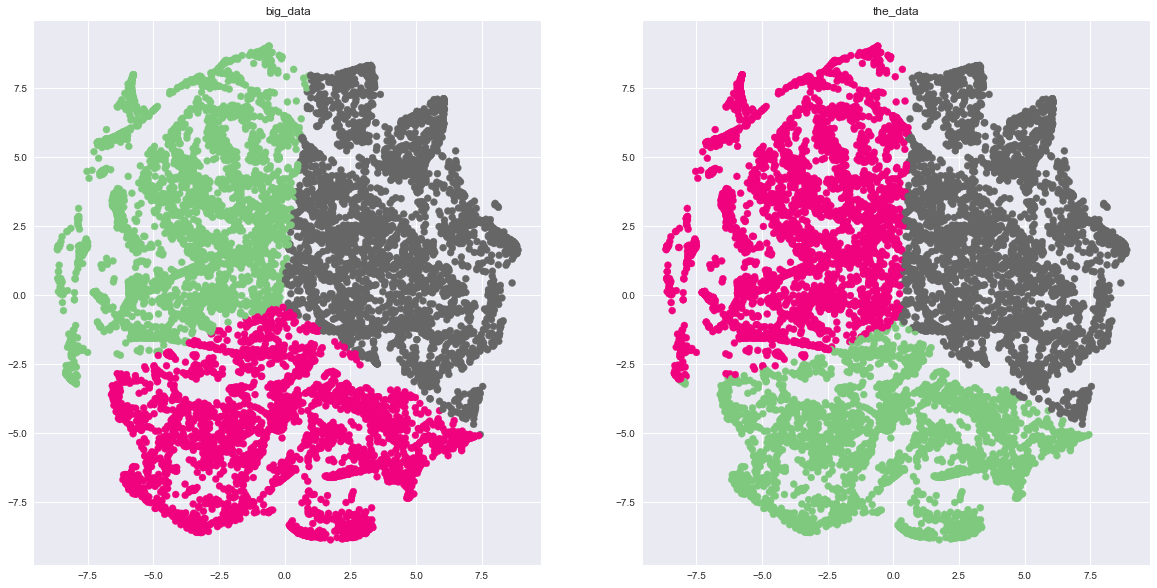

In [209]:
#colors = np.array(['red', 'lime', 'black'])

fig = plt.figure(figsize=(20,10))
plt.subplot2grid((1,2), (0,0))
plt.title('big_data')
plt.scatter(result[:,0], result[:,1], c=labels, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((1,2), (0,1))
plt.title('the_data')
plt.scatter(result[:,0], result[:,1], c=labels1, cmap=plt.cm.get_cmap("Accent", 4))
plt.show()

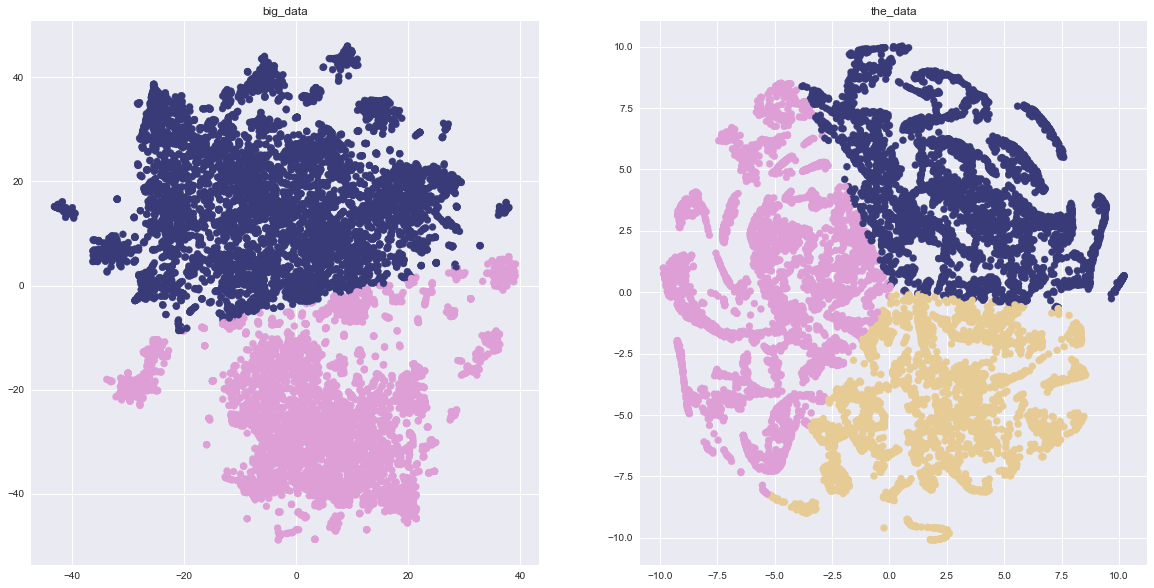

In [48]:
fig = plt.figure(figsize=(20,10))
plt.subplot2grid((1,2), (0,0))
plt.title('big_data')
plt.scatter(result_bh[:,0], result_bh[:,1], c=labels2, cmap=plt.cm.get_cmap("Vega20b", 10))
plt.subplot2grid((1,2), (0,1), rowspan=1, colspan=2)
plt.title('the_data')
plt.scatter(result2[:,0], result2[:,1], c=labels3, cmap=plt.cm.get_cmap("Vega20b", 10))
plt.show()

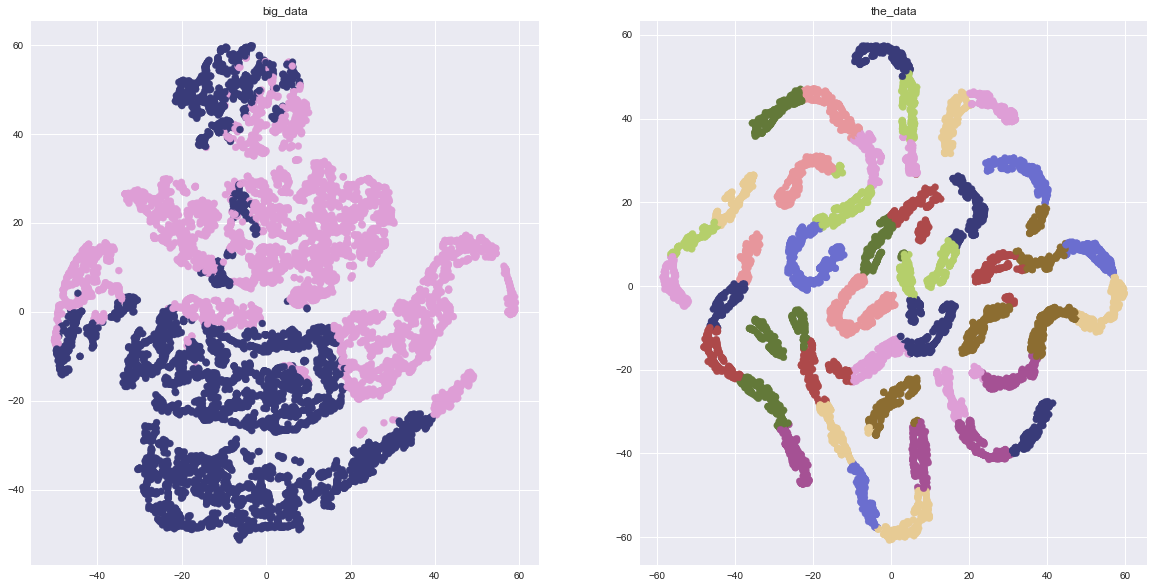

In [201]:
fig = plt.figure(figsize=(20,10))
plt.subplot2grid((1,2), (0,0))
plt.title('big_data')
plt.scatter(result_emb_bh_the_data[:,0], result_emb_bh_the_data[:,1], c=labels4, cmap=plt.cm.get_cmap("Vega20b", 10))
plt.subplot2grid((1,2), (0,1), rowspan=1, colspan=2)
plt.title('the_data')
plt.scatter(result_bh_the_data[:,0], result_bh_the_data[:,1], c=labels5, cmap=plt.cm.get_cmap("Vega20b", 10))
plt.show()

# So wazz up?


Hægt að snúa þessu á fleiri kanta en ég ákvað að horfa eingöngu á mínúturnar og skilja eftir þætti eins og aldur og kyn. 